


# DBSCAN & HDBSCAN clustering
    
In questa esercitazione si implementano i modelli di clustering `DBSCAN` e `hdbscan` per applicarli sui dati di StatCan contenenti nome, tipologia e località delle strutture di arte e cultura in Canada.

Data source: The Open Database of Cultural and Art Facilities (ODCAF)

Landing page:
https://www.statcan.gc.ca/en/lode/databases/odcaf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

# geographical tools
import geopandas as gpd  # pandas dataframe-like geodataframes for geographical data
!pip install contextily==1.6.2
import contextily as ctx  # used for obtianing a basemap of Canada
!pip install shapely==2.0.6
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

## Download della mappa del Canada
Sarà utile per visualizzare correttamente l'output dei modelli.


In [2]:
import requests
import zipfile
import io
import os

# URL of the ZIP file on the cloud server
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'

# Directory to save the extracted TIFF file
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Download the ZIP file
response = requests.get(zip_file_url)
response.raise_for_status()  # Ensure the request was successful
# Step 2: Open the ZIP file in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    # Step 3: Iterate over the files in the ZIP
    for file_name in zip_ref.namelist():
        if file_name.endswith('.tif'):  # Check if it's a TIFF file
            # Step 4: Extract the TIFF file
            zip_ref.extract(file_name, output_dir)
            print(f"Downloaded and extracted: {file_name}")

Downloaded and extracted: Canada.tif


## Funzione per il plot



In [3]:

def plot_clustered_locations(df,  title='Museums Clustered by Proximity'):
    """
    Plots clustered locations and overlays on a basemap.

    Parameters:
    - df: DataFrame containing 'Latitude', 'Longitude', and 'Cluster' columns
    - title: str, title of the plot
    """

    # Load the coordinates intto a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")

    # Reproject to Web Mercator to align with basemap
    gdf = gdf.to_crs(epsg=3857)

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Separate non-noise, or clustered points from noise, or unclustered points
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]

    # Plot noise points
    noise.plot(ax=ax, color='k', markersize=30, ec='r', alpha=1, label='Noise')

    # Plot clustered points, colured by 'Cluster' number
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=False, alpha=0.6)

    # Add basemap of  Canada
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)

    # Format plot
    plt.title(title, )
    plt.xlabel('Longitude', )
    plt.ylabel('Latitude', )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    # Show the plot
    plt.show()

## Analisi del dataset

In [5]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")
df.sample(5)

Index                       Facility_Name  \
7128   8809                   Terry Fox Library   
5143   6300       Moose River Gold Mines Museum   
3193   3851           Fort Erie Railroad Museum   
6006   7477              Ponoka Jubilee Library   
698     865  Bibliothèque Du Plateau-Mont-Royal   

                                 Source_Facility_Type  ODCAF_Facility_Type  \
7128                   fraser valley regional library  library or archives   
5143  community/regional museum industry/trade museum               museum   
3193                                               ..               museum   
6006                                               ..  library or archives   
698                                                ..  library or archives   

                            Provider Unit Street_No         Street_Name  \
7128  government of british columbia   ..      2470     mary hilld road   
5143    canadian museums association   ..      6990          moose road   
3193                  niagara region   ..       400         central ave   
6006           government of alberta   ..      5604           50 street   
698                ville de montréal   ..       465  du-mont avenue est   

     Postal_Code          City Prov_Terr  \
7128     V3C 3B1        midway        bc   
5143     B0J 2L0  musquodoboit        ns   
3193          ..     fort erie        on   
6006     T4J 1G5        ponoka        ab   
698      H2J 1W3      montréal        qc   

                                  Source_Format_Address        CSD_Name  \
7128                                2470 mary hill road  Port Coquitlam   
5143  6990 moose river road musquodoboit nova scotia...         Halifax   
3193                                    400 central ave       Fort Erie   
6006                                   5604 - 50 street          Ponoka   
698                       465, avenue du mont-royal est        Montréal   

       CSDUID PRUID     Latitude     Longitude  
7128  5915039    59    49.260305   -122.778532  
5143  1209034    12  44.99801076  -62.95123543  
3193  3526003    35  42.92287748  -78.91746617  
6006  4808039    48           ..            ..  
698   2466023    24   45.5248239   -73.5823694

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7972 entries, 0 to 7971
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Index                  7972 non-null   int64 
 1   Facility_Name          7972 non-null   object
 2   Source_Facility_Type   7972 non-null   object
 3   ODCAF_Facility_Type    7972 non-null   object
 4   Provider               7972 non-null   object
 5   Unit                   7972 non-null   object
 6   Street_No              7972 non-null   object
 7   Street_Name            7972 non-null   object
 8   Postal_Code            7972 non-null   object
 9   City                   7972 non-null   object
 10  Prov_Terr              7972 non-null   object
 11  Source_Format_Address  7972 non-null   object
 12  CSD_Name               7972 non-null   object
 13  CSDUID                 7972 non-null   object
 14  PRUID                  7972 non-null   object
 15  Latitude             

In [7]:
# Etichette
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

In [8]:
# Selezione dei soli musei
df = df.loc[ df.ODCAF_Facility_Type == 'museum' ]
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
museum    1938
Name: count, dtype: int64

In [9]:
# Prendo come features solo Latitudine e Longitudine
df = df[['Latitude', 'Longitude']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1938 entries, 1 to 7969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   1938 non-null   object
 1   Longitude  1938 non-null   object
dtypes: object(2)
memory usage: 45.4+ KB


In [10]:
# Rimuovo osservazioni incomplete
df = df[df.Latitude!='..']

# Conversione a float
df[['Latitude','Longitude']] = df[['Latitude','Longitude']].astype('float')

## DBSCAN



In [11]:
# In this case we know how to scale the coordinates. Using standardization would be an error becaues we aren't using the full range of the lat/lng coordinates.
# Since latitude has a range of +/- 90 degrees and longitude ranges from 0 to 360 degrees, the correct scaling is to double the longitude coordinates (or half the Latitudes)
coords_scaled = df.copy()
coords_scaled["Latitude"] = 2*coords_scaled["Longitude"]

In [13]:
min_samples=3  # numero minimo di punti per formare un gruppo
eps=1.0  # raggio del gruppo
metric='euclidean'  # misura della distanza

dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(coords_scaled)
# Aggiungo al dataframe le labels trovate dal modello
df['Cluster'] = dbscan.fit_predict(coords_scaled)
df['Cluster'].value_counts()

Cluster
 1     981
 2     224
 5     214
 3      82
 4      31
 6      17
-1      13
 7      13
 0       7
 10      6
 8       5
 9       5
 11      3
 12      3
 13      3
Name: count, dtype: int64

I punti etichettati -1 sono classificati come rumore.


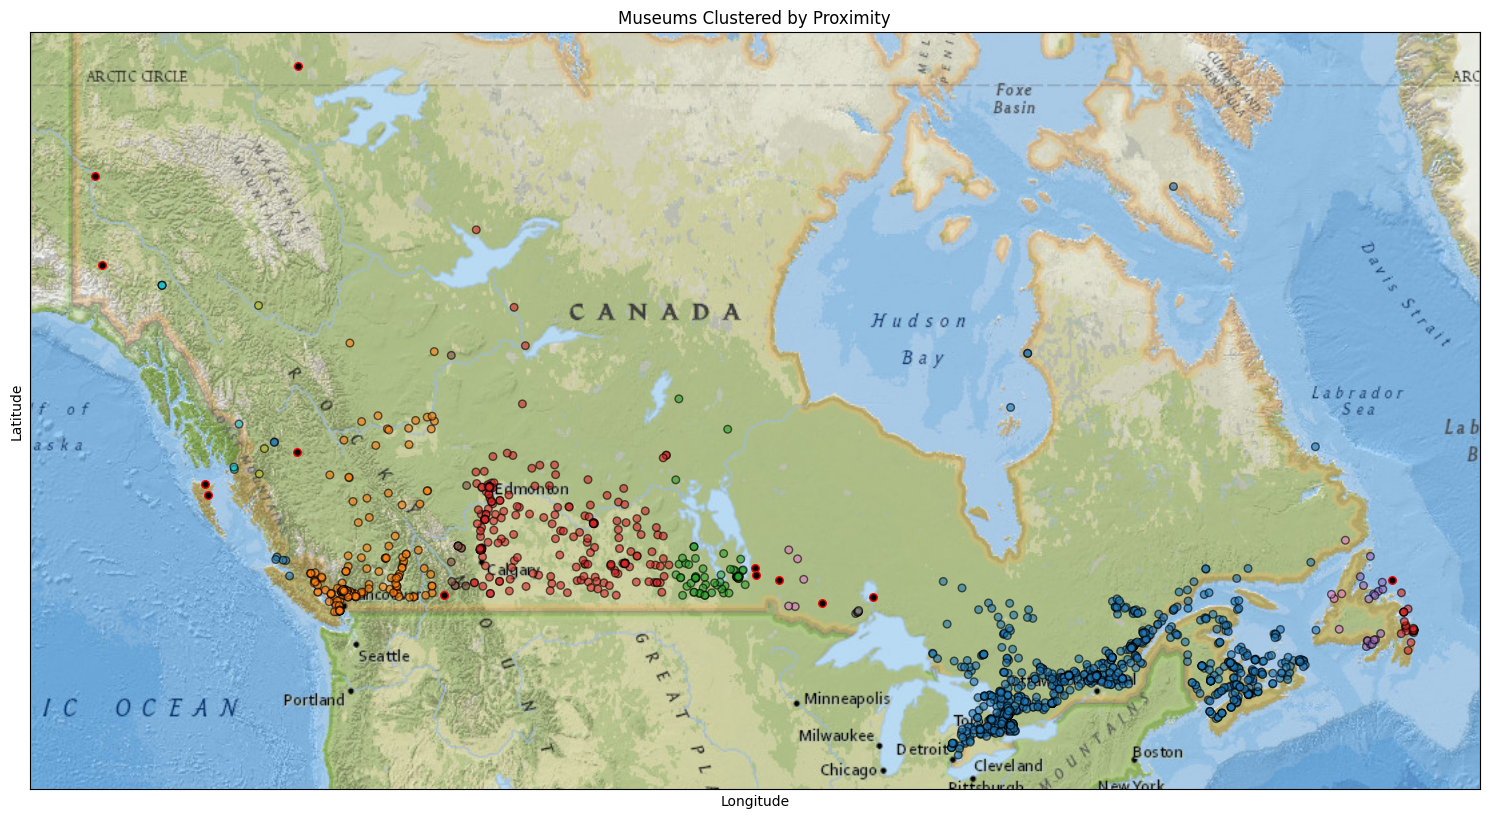

In [14]:
plot_clustered_locations(df, title='Museums Clustered by Proximity')



- I cluster non hanno tutti la stessa densità;
- Il risultato può essere migliorato con HDBSCAN.


## HDBSCAN



In [16]:
min_samples=None
min_cluster_size=3
hdb = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric='euclidean')

df['Cluster'] = hdb.fit_predict(coords_scaled)
df['Cluster'].value_counts()

Cluster
-1      276
 26      41
 84      39
 145     28
 40      20
       ... 
 166      3
 86       3
 98       3
 138      3
 111      3
Name: count, Length: 175, dtype: int64

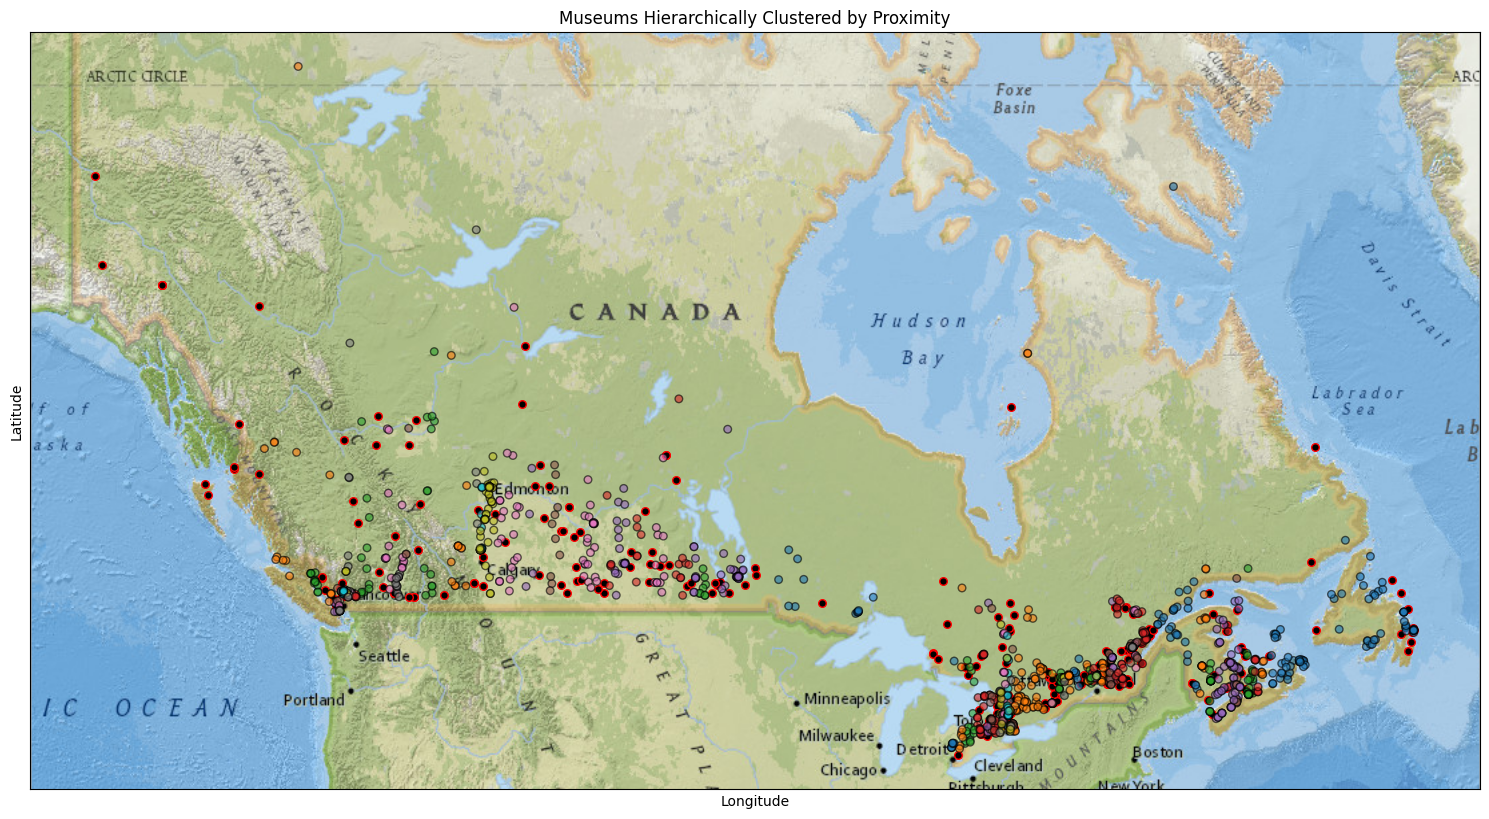

In [17]:
# Plot the museum clusters
plot_clustered_locations(df, title='Museums Hierarchically Clustered by Proximity')

I cluster adesso hanno una densità uniforme e molti più punti sono stati classificati come rumore.
